#### Imports

In [1]:
# Basic imports & versions
import sys, os, json, time, copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch as th
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.callbacks import BaseCallback
from utils.env_utils import keep_only_electrical_storage, keep_only_core_observations, PPOTrainLogger, DiscretizeActionWrapper, PowerScaledDiscreteActions
import citylearn
from citylearn.data import DataSet
from citylearn.citylearn import CityLearnEnv
from citylearn.wrappers import NormalizedObservationWrapper, StableBaselines3Wrapper

print('Python:', sys.version.split()[0])
print('Torch :', th.__version__)
print('CityLearn:', citylearn.__version__)

Couldn't import dot_parser, loading of dot files will not be possible.


2025-09-18 13:53:56.173488: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-18 13:53:56.187685: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758196436.203455 3755791 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758196436.207870 3755791 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1758196436.219901 3755791 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Python: 3.11.7
Torch : 2.7.0+cu126
CityLearn: 2.4.1


#### Variables

In [3]:
# Configuration
DATASET_NAME = 'citylearn_challenge_2023_phase_3_1'  # adjust if needed
ROOT_DIR = r'/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1'
LOG_DIR = r'/hkfs/home/haicore/iai/cj9272/logs/ppo'
REWARD_FN = {  # CostReward 
    'type': 'citylearn.reward_function.CostReward',
    'attributes': {}
}
PRICING_FILE = 'pricing_germany_2023_june_to_august.csv' 
ACTION_LABELS = ['discharge_full', 'discharge_half', 'idle', 'charge_half', 'charge_full']
ONLY_ELECTRICAL_STORAGE = True
EVAL_EPISODES = 10
INT_TO_FRAC = np.array([-1.0, -0.5, 0.0, 0.5, 1.0], dtype=np.float32)

In [4]:
# --- Load schema ---
dataset = DataSet()
schema = dataset.get_schema(DATASET_NAME)
schema['root_directory'] = ROOT_DIR
schema['reward_function'] = REWARD_FN 

price_file = PRICING_FILE # Set pricing file
if 'buildings' not in schema:
    raise RuntimeError("schema does not contain 'buildings' (make sure schema is loaded)")
for bname, bconf in schema['buildings'].items():
    bconf['pricing'] = price_file

schema = keep_only_electrical_storage(schema)
schema = keep_only_core_observations(schema, extra_keep=['carbon_intensity', 'non_shiftable_load'], drop_predictions=False)

# Keep only one building: 1-D action
one_building = "Building_1"
schema_1b = dict(schema)  # shallow copy
schema_1b['buildings'] = {k: v for k, v in schema['buildings'].items() if k == one_building}
if not schema_1b['buildings']:
    raise RuntimeError(f"{one_building} not found in schema['buildings']")

env = CityLearnEnv(schema_1b, central_agent=True) # create env
# check initialization
print('Initial time step:', env.time_step)
print('Number of time steps:', env.time_steps)
print('Central agent:', env.central_agent)
print('Number of buildings:', len(env.buildings))
print('Electrical storage capacity:', {
    b.name: b.electrical_storage.capacity for b in env.buildings
})
print('Action_space [Box(low_limit, high_limit), shape, datatype]:', env.action_space)
print('Number of Observations:', len(env.observations[0]))

INFO:root:Go here /home/iai/cj9272/.cache/citylearn/v2.4.1/datasets/citylearn_challenge_2023_phase_3_1/schema.json 


/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-09-18_13-54-06'
Initial time step: 0
Number of time steps: 2208
Central agent: True
Number of buildings: 1
Electrical storage capacity: {'Building_1': 4.0}
Action_space [Box(low_limit, high_limit), shape, datatype]: [Box(-1.0, 1.0, (1,), float32)]
Number of Observations: 6


In [ ]:
import os, csv, time
from typing import List, Optional, Sequence, Any, Dict
import numpy as np
import pandas as pd
from stable_baselines3.common.callbacks import BaseCallback

class TrainStepCSVLogger(BaseCallback):
    """
    Step-wise CSV logger for SB3 (works with PPO, A2C, etc., and with VecEnvs/Monitor).
    - Writes rows: [step, env_id, episode, action_id, action_label, action_frac, reward]
    - Robust action extraction: tries info[...] first, then raw action; can quantize to the nearest allowed fraction.
    - Keeps episode counters per env_id.
    - After training, exposes:
        self.df     -> pandas.DataFrame of all step rows
        self.ep_df  -> pandas.DataFrame aggregated by episode (return, length) per env
    """
    def __init__(
        self,
        save_dir="logs/ppo",
        filename="train_steps.csv",
        action_labels=None,   
        action_fracs=None,  
        flush_every_steps=5000,
        verbose=0
    ):
        super().__init__(verbose)
        self.save_dir = save_dir
        self.filepath = os.path.join(save_dir, filename)
        self.action_labels = list(action_labels) if action_labels is not None else None
        self.action_fracs = np.asarray(action_fracs, dtype=float) if action_fracs is not None else None
        self.flush_every_steps = int(flush_every_steps)

        # runtime state
        self._fh = None
        self._writer = None
        self._rows = []
        self._t0 = None
        self._ep_counters = None
        self.df = None
        self.ep_df = None

    # ---------- helpers ----------
    @staticmethod
    def _unwrap_to_citylearn(env):
        cur, seen = env, set()
        while cur is not None and id(cur) not in seen:
            seen.add(id(cur))
            if isinstance(cur, CityLearnEnv):
                return cur
            cur = getattr(cur, "env", getattr(cur, "unwrapped", None))
        return None

    def _get_citylearn_env_for_idx(self, idx: int):
        # DummyVecEnv hat .envs, SubprocVecEnv nutzt env_method/get_attr, aber hier meist DummyVecEnv.
        venv = self.training_env
        base = None
        if hasattr(venv, "envs"):                 # DummyVecEnv
            base = self._unwrap_to_citylearn(venv.envs[idx])
        else:
            try:
                base = self._unwrap_to_citylearn(venv.get_attr("env")[idx])
            except Exception:
                base = None
        return base

    # ---- lifecycle hooks ----
    def _on_training_start(self) -> None:
        os.makedirs(self.save_dir, exist_ok=True)
        self._t0 = time.time()
        n_envs = int(getattr(self.training_env, "num_envs", 1))
        self._current_ep_counts = [0]*n_envs

        new_file = not os.path.exists(self.filepath) or os.path.getsize(self.filepath) == 0
        self._fh = open(self.filepath, "a", newline="")
        self._writer = csv.writer(self._fh)
        if new_file:
            self._writer.writerow([
                # meta
                "global_step","time_sec","env_id","episode",
                # action + reward
                "action_id","action_label","action_frac","reward",
                # CityLearn internals (t-1; konsistent mit obs)
                "price","net_load","non_shiftable_load","cooling_load","heating_load","dhw_load",
                "chargers_load","storage_load","solar","battery_soc","battery_energy_balance",
                "simulate_power_outage","power_outage"
            ])
            self._fh.flush()

    def _on_step(self) -> bool:
        obs_vec = self.locals.get("new_obs")
        acts    = self.locals.get("actions")
        rews    = self.locals.get("rewards")
        dones   = self.locals.get("dones")
        infos   = self.locals.get("infos", [])
        step    = int(self.num_timesteps)

        n_envs = len(rews) if hasattr(rews, "__len__") else 1
        for idx in range(n_envs):
            act  = acts[idx] if hasattr(acts, "__len__") else acts
            rew  = rews[idx] if hasattr(rews, "__len__") else rews
            done = bool(dones[idx]) if hasattr(dones, "__len__") else bool(dones)

            # Extract discrete action ID
            try:
                a_id = int(act) if np.isscalar(act) else int(np.array(act).reshape(-1)[0])
            except Exception:
                a_id = None

            # Label & Frac
            a_label = (self.action_labels[a_id] if (a_id is not None and 0 <= a_id < len(self.action_labels)) else None)
            a_frac  = (float(self.action_fracs[a_id]) if (a_id is not None and 0 <= a_id < len(self.action_fracs)) else None)

            row = {
                "global_step": step,
                "time_sec": f"{time.time()-self._t0:.3f}",
                "env_id": idx,
                "episode": self._current_ep_counts[idx],
                "action_id": (a_id if a_id is not None else ""),
                "action_label": a_label if a_label is not None else "",
                "action_frac": f"{a_frac:.1f}" if a_frac is not None else "",
                "reward": f"{float(rew):.6f}",
                # CityLearn Felder folgen, evtl. leer
                "price": "", "net_load": "", "non_shiftable_load": "",
                "cooling_load": "", "heating_load": "", "dhw_load": "",
                "chargers_load": "", "storage_load": "", "solar": "",
                "battery_soc": "", "battery_energy_balance": "",
                "simulate_power_outage": "", "power_outage": ""
            }

            # CityLearn-Interna (t-1 = consistent to obs)
            try:
                base = self._get_citylearn_env_for_idx(idx)
                if base is not None and len(base.buildings) > 0:
                    b = base.buildings[0]
                    t  = int(getattr(b, "time_step", 0))
                    tp = max(0, t-1)

                    chargers_arr = getattr(b, "_Building__chargers_electricity_consumption", None)
                    chargers_tp  = float(chargers_arr[tp]) if chargers_arr is not None else np.nan

                    row.update({
                        "price": float(b.pricing.electricity_pricing[tp]),
                        "net_load": float(b.net_electricity_consumption[tp]),
                        "non_shiftable_load": float(b.non_shiftable_load_device.electricity_consumption[tp]),
                        "cooling_load": float(b.cooling_device.electricity_consumption[tp]),
                        "heating_load": float(b.heating_device.electricity_consumption[tp]),
                        "dhw_load": float(b.dhw_device.electricity_consumption[tp]),
                        "chargers_load": chargers_tp,
                        "storage_load": float(b.electrical_storage.electricity_consumption[tp]),
                        "solar": float(b.solar_generation[tp]),
                        "battery_soc": float(b.electrical_storage.soc[tp]),
                        "battery_energy_balance": float(b.electrical_storage.energy_balance[tp]),
                        "simulate_power_outage": bool(getattr(b, 'simulate_power_outage', False)),
                        "power_outage": bool(getattr(b, 'power_outage', False)),
                    })
            except Exception:
                pass

            row_df = {
                "global_step": step,
                "env_id": idx,
                "episode": self._current_ep_counts[idx],
                "action_id": a_id if a_id is not None else None,
                "action_label": a_label if a_label is not None else None,
                "action_frac": float(a_frac) if a_frac is not None else None,
                "reward": float(rew),
                "price": row["price"] if row["price"] != "" else None,
                "net_load": row["net_load"] if row["net_load"] != "" else None,
                "non_shiftable_load": row["non_shiftable_load"] if row["non_shiftable_load"] != "" else None,
                "cooling_load": row["cooling_load"] if row["cooling_load"] != "" else None,
                "heating_load": row["heating_load"] if row["heating_load"] != "" else None,
                "dhw_load": row["dhw_load"] if row["dhw_load"] != "" else None,
                "chargers_load": row["chargers_load"] if row["chargers_load"] != "" else None,
                "storage_load": row["storage_load"] if row["storage_load"] != "" else None,
                "solar": row["solar"] if row["solar"] != "" else None,
                "battery_soc": row["battery_soc"] if row["battery_soc"] != "" else None,
                "battery_energy_balance": row["battery_energy_balance"] if row["battery_energy_balance"] != "" else None,
            }
            self._rows.append(row_df)


            # write CSV row
            self._writer.writerow([
                row["global_step"], row["time_sec"], row["env_id"], row["episode"],
                row["action_id"], row["action_label"], row["action_frac"], row["reward"],
                row["price"], row["net_load"], row["non_shiftable_load"], row["cooling_load"], row["heating_load"],
                row["dhw_load"], row["chargers_load"], row["storage_load"], row["solar"],
                row["battery_soc"], row["battery_energy_balance"],
                row["simulate_power_outage"], row["power_outage"]
            ])

            if done:
                self._current_ep_counts[idx] += 1

        if self.flush_every_steps and (self.num_timesteps % self.flush_every_steps == 0):
            self._fh.flush()
        return True

    def _on_training_end(self) -> None:
        if self._fh is not None:
            self._fh.flush()
            self._fh.close()
            self._fh = None
            self._writer = None
        if self._rows:
            self.df = pd.DataFrame(self._rows)
            self.ep_df = (self.df.groupby(["env_id","episode"], as_index=False)
                            .agg(ep_return=("reward","sum"),
                                ep_length=("reward","size")))

In [6]:
class RewardScalar(gym.Wrapper):
    """Macht aus CityLearn-Reward (Liste oder Array) einen Float für SB3/Monitor."""
    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        # reward kann Liste / np.array / Skalar sein -> robust zu Float machen
        reward = float(np.asarray(reward).sum())
        return obs, reward, terminated, truncated, info

def compute_action_scales(cl_env, alpha=0.8):
    """scale = alpha * (P_nom * dt / capacity). alpha<1 gibt Headroom -> weniger Clipping."""
    dt_h = cl_env.schema['seconds_per_time_step'] / 3600.0
    scales = []
    for b in cl_env.buildings:
        cap  = max(b.electrical_storage.capacity, 1e-9)   # kWh
        pnom = b.electrical_storage.nominal_power         # kW
        scales.append(alpha * (pnom * dt_h) / cap)
    return np.array(scales, dtype=np.float32)

os.makedirs(LOG_DIR, exist_ok=True)
scales = compute_action_scales(env) 
print("Action scales (pro Building):", scales)

train_env = NormalizedObservationWrapper(env)
train_env = StableBaselines3Wrapper(train_env)
train_env = PowerScaledDiscreteActions(train_env, scales=scales)
train_env = Monitor(train_env, filename=os.path.join(LOG_DIR, "monitor.csv"))
print('Train action_space:', train_env.action_space)

#train_callback = PPOTrainLogger()
train_callback = TrainStepCSVLogger(
    save_dir=LOG_DIR,
    filename="ppo_train_steps_01.csv",
    action_labels=ACTION_LABELS,    
    action_fracs=INT_TO_FRAC
)
TOTAL_TIMESTEPS = 2207 * 50

model = PPO(
    policy='MlpPolicy',
    env=train_env,
    seed=1, # seed for pseudo random generators
    device='cpu', # ppo is intended to run on cpu
    learning_rate=0.00284168226539535,
    gamma=0.971587814014358,
    ent_coef=0.05885182459088836,
    vf_coef=0.9901724232320459,
    gae_lambda=0.884166238447603,
    n_steps=64,
    batch_size=128,
    n_epochs=8,
    clip_range=0.21369082195658376,
    verbose=1, # logging: info
    policy_kwargs=dict(net_arch=[256,256], activation_fn=th.nn.ReLU)
)
TRAINING_FILE = "ppo_01" # 
TRAIN_STEPS_FILE = os.path.join(LOG_DIR, "ppo_train_steps_01.csv") # num
TRAIN_EPISODES_FILE = os.path.join(LOG_DIR, "ppo_train_episodes_01.csv") # num

Action scales (pro Building): [0.664]
Train action_space: Discrete(5)
Using cpu device
Wrapping the env in a DummyVecEnv.


/hkfs/home/haicore/iai/cj9272/citylearn_env/lib64/python3.11/site-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 128, but because the `RolloutBuffer` is of size `n_steps * n_envs = 64`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 64
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=64 and n_envs=1)
  warnings.warn(


In [6]:
# ca 100min
start_time = time.time()
model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=train_callback)
print(f"Total time elapsed for {TOTAL_TIMESTEPS} steps: {(time.time()-start_time):.2f} seconds")
model.save(TRAINING_FILE)  
print(f"PPO model saved to {os.path.abspath(TRAINING_FILE)}")

print("---------------Train callback: \n", train_callback.df)
print("---------------Episode rewards: \n", train_callback.ep_df)
# Save training logs

train_callback.df.to_csv(TRAIN_STEPS_FILE, index=False)
train_callback.ep_df.to_csv(TRAIN_EPISODES_FILE, index=False)

----------------------------
| time/              |     |
|    fps             | 136 |
|    iterations      | 1   |
|    time_elapsed    | 0   |
|    total_timesteps | 64  |
----------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 2          |
|    time_elapsed         | 1          |
|    total_timesteps      | 128        |
| train/                  |            |
|    approx_kl            | 0.03391163 |
|    clip_fraction        | 0.344      |
|    clip_range           | 0.214      |
|    entropy_loss         | -1.59      |
|    explained_variance   | -0.0141    |
|    learning_rate        | 0.00284    |
|    loss                 | -0.103     |
|    n_updates            | 8          |
|    policy_gradient_loss | -0.034     |
|    value_loss           | 0.0851     |
----------------------------------------
-----------------------------------------
| time/          

In [9]:
# Quick learning check on training episodes
if hasattr(train_callback, 'ep_df') and len(train_callback.ep_df):
    ep_df = train_callback.ep_df
    first_n, last_n = 10, 10
    first_mean = ep_df['ep_return'].head(first_n).mean()
    last_mean  = ep_df['ep_return'].tail(last_n).mean()
    print(f'First {first_n} ep mean return: {first_mean:.3f}')
    print(f'Last  {last_n} ep mean return: {last_mean:.3f}')
    print('Learning indicator (last - first):', f'{(last_mean-first_mean):.3f}')
else:
    print('No episode returns in train_callback.ep_df')

First 10 ep mean return: -263.629
Last  10 ep mean return: -237.985
Learning indicator (last - first): 25.644


#### Evaluation

In [17]:
schema_eval = copy.deepcopy(schema_1b)

_raw_eval_env = CityLearnEnv(schema_eval, central_agent=True)

eval_scales = compute_action_scales(_raw_eval_env)
print("Eval action scales:", eval_scales)

eval_env = NormalizedObservationWrapper(_raw_eval_env)
eval_env = StableBaselines3Wrapper(eval_env)
eval_env = PowerScaledDiscreteActions(eval_env, scales=eval_scales)

print('Eval action_space:', eval_env.action_space)

model = PPO.load(TRAINING_FILE)
print(f"PPO model loaded from {os.path.abspath(TRAINING_FILE)}")

EVAL_FILE = os.path.join(LOG_DIR, "ppo_eval_01.pkl")


/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-09-18_13-58-20'
Eval action scales: [0.664]
Eval action_space: Discrete(5)
PPO model loaded from /hkfs/home/haicore/iai/cj9272/ppo_01


/hkfs/home/haicore/iai/cj9272/citylearn_env/lib64/python3.11/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


In [ ]:
# ca 25min
# Enhanced eval: timings, episode length, per-step stats, deterministic toggle.
def evaluate_with_metrics(model, env, episodes=5, deterministic=True, render=False, save_path=None):
    import pickle
    from citylearn.citylearn import CityLearnEnv

    def action_to_frac(env, action):
        if isinstance(env.action_space, gym.spaces.Discrete):
            return np.array([INT_TO_FRAC[int(action)]], dtype=np.float32)
        elif isinstance(env.action_space, gym.spaces.MultiDiscrete):
            a = np.asarray(action, dtype=int)
            return INT_TO_FRAC[a]
        else:
            return np.asarray(action, dtype=np.float32)

    def _get_base_env(e):
        cur, seen = e, set()
        while cur is not None and id(cur) not in seen:
            seen.add(id(cur))
            if isinstance(cur, CityLearnEnv):
                return cur
            cur = getattr(cur, "env", getattr(cur, "unwrapped", None))
        raise RuntimeError("CityLearnEnv not found inside wrappers.")

    base = _get_base_env(env)
    bld_names = [b.name for b in base.buildings]
    building_name = "Building_1" if "Building_1" in bld_names else bld_names[0]
    b_idx = bld_names.index(building_name)

    obs_names = getattr(base, "observation_names", None)
    if obs_names is None:
        raise AttributeError("CityLearnEnv has no 'observation_names'.")
    obs_b = obs_names[b_idx]
    name_to_idx = {n: i for i, n in enumerate(obs_b)}
    i_net = name_to_idx.get("net_electricity_consumption")
    if i_net is None:
        i_net = name_to_idx.get("net_electricity_consumption_without_storage")
    i_nsl   = name_to_idx.get("non_shiftable_load")
    i_price = name_to_idx.get("electricity_pricing")
    i_solar = name_to_idx.get("solar_generation")

    ep_metrics, all_step_rewards, all_kpis, all_actions = [], [], [], []
    ep_lengths = []
    actions_disc_list, ep_action_fracs = [], []
    ep_rewards_list = []
    ep_net_load, ep_non_shiftable_load, ep_price, ep_solar_generation = [], [], [], []

    t_global_start = time.time()

    for ep in range(1, episodes + 1):
        obs, _ = env.reset()
        done = False
        ep_ret, ep_len = 0.0, 0
        step_rewards = []
        action_list = []
        last_info = None


        ep_actions_disc = []
        ep_fracs = []
        ep_net, ep_nsl, ep_prc, ep_sol = [], [], [], []

        t_ep_start = time.time()
        while not done:
            action, _ = model.predict(obs, deterministic=deterministic)
            frac = action_to_frac(env, action)
            action_list.append(frac)

            obs, r, terminated, truncated, info = env.step(action)
            last_info = info
            done = bool(terminated or truncated)
            # central Agent -> r is list of length 1
            if isinstance(r, (list, tuple, np.ndarray)):
                r = float(r[0])

            # Optionaler Sanity-Check mit Monitor:
            if isinstance(last_info, dict) and 'episode' in last_info:
                assert abs(ep_ret - float(last_info['episode']['r'])) < 1e-5

            if isinstance(env.action_space, gym.spaces.Discrete):
                a_id = int(action)
            else:
                a_id = int(np.argmin(np.abs(INT_TO_FRAC - float(frac[0]))))

            ep_actions_disc.append(a_id)
            ep_fracs.append(float(INT_TO_FRAC[a_id]))
            step_rewards.append(float(r))
            ep_ret += float(r)
            ep_len += 1

            raw = base.observations[b_idx]
            ep_net.append(float(raw[i_net]) if i_net is not None else np.nan)
            ep_nsl.append(float(raw[i_nsl]) if i_nsl is not None else np.nan)
            ep_prc.append(float(raw[i_price]) if i_price is not None else np.nan)
            ep_sol.append(float(raw[i_solar]) if i_solar is not None else np.nan)

            if render:
                env.render()

        kpis = env.unwrapped.evaluate()
        all_kpis.append(kpis)
        all_actions.append(np.vstack(action_list))

        t_ep = time.time() - t_ep_start
        steps_per_sec = ep_len / max(t_ep, 1e-9)
        ep_metrics.append({
            'episode': ep, 'cumulative reward': ep_ret, 'length': ep_len,
            'mean_reward': ep_ret/ep_len if ep_len else np.nan,
            'min_step_reward': float(np.min(step_rewards)),
            'max_step_reward': float(np.max(step_rewards)),
            'std_step_reward': float(np.std(step_rewards)),
            'steps_per_sec': steps_per_sec, 'wall_time_s': t_ep
        })
        all_step_rewards.extend(step_rewards)

        ep_lengths.append(ep_len)
        actions_disc_list.append(np.asarray(ep_actions_disc, dtype=int))
        ep_action_fracs.append(np.asarray(ep_fracs, dtype=float))
        ep_rewards_list.append(np.asarray(step_rewards, dtype=float))
        ep_net_load.append(np.asarray(ep_net, dtype=float))
        ep_non_shiftable_load.append(np.asarray(ep_nsl, dtype=float))
        ep_price.append(np.asarray(ep_prc, dtype=float))
        ep_solar_generation.append(np.asarray(ep_sol, dtype=float))

        print(f"[Eval] Ep {ep}/{episodes} return={ep_ret:.3f} len={ep_len} "
              f"mean={ep_ret/ep_len:.3f} time={t_ep:.2f}s speed={steps_per_sec:.1f} steps/s")

    print(f"Total eval time: {time.time()-t_global_start:.2f}s  | Avg/ep: {(time.time()-t_global_start)/episodes:.2f}s")
    metrics_df = pd.DataFrame(ep_metrics)
    display(metrics_df)

    price_file = schema['buildings'][building_name]['pricing']
    price_path = os.path.join(ROOT_DIR, price_file)
    prc_df = pd.read_csv(price_path)
    T = len(prc_df)

    results = {
        'ep_lengths': np.asarray(ep_lengths, dtype=int),
        'actions_disc_list': actions_disc_list,
        'step_rewards': np.asarray(all_step_rewards, dtype=float),

        'ep_action_fracs': ep_action_fracs,
        'ep_rewards_list': ep_rewards_list,
        'ep_net_load': ep_net_load,
        'ep_non_shiftable_load': ep_non_shiftable_load,
        'ep_price': ep_price,
        'ep_solar_generation': ep_solar_generation,

        'price_df': prc_df,
        'episode_len': T,
        'building_name': building_name,

        'metrics_df': metrics_df,
        'episode_kpis': all_kpis,
    }
    print(f"Eval results: {list(results.keys())}")
    if save_path is not None:
        with open(save_path, "wb") as f:
            pickle.dump(results, f)
        print(f"PPO eval results saved to {os.path.abspath(save_path)}")

    return metrics_df, np.array(all_step_rewards), all_kpis, all_actions

# Deterministic
metrics_det, step_rewards_det, kpis_det, actions_det = evaluate_with_metrics(
    model, eval_env, episodes=EVAL_EPISODES, deterministic=True, save_path=EVAL_FILE
)

In [ ]:
def preview_rewards(model, env, steps=48, deterministic=True):
    obs, _ = env.reset()
    cum = 0.0
    for t in range(steps):
        action, _ = model.predict(obs, deterministic=deterministic)
        obs, r, done, trunc, info = env.step(action)
        # CityLearn gibt bei central_agent i.d.R. eine Liste zurück
        r = float(r[0]) if isinstance(r, (list, tuple, np.ndarray)) else float(r)
        cum += r
        print(f"[eval] t={t:04d} r={r:.4f}  cum={cum:.4f}")
        if done or trunc:
            print(f"[eval] episode end at t={t}, return={cum:.4f}")
            break

# Aufrufen, sobald model & eval_env bereit sind:
preview_rewards(model, eval_env, steps=96, deterministic=True)

[eval] t=0000 r=-0.0926  cum=-0.0926
[eval] t=0001 r=-0.0390  cum=-0.1317
[eval] t=0002 r=-0.0282  cum=-0.1599
[eval] t=0003 r=-0.0245  cum=-0.1844
[eval] t=0004 r=-0.0297  cum=-0.2141
[eval] t=0005 r=-0.0728  cum=-0.2870
[eval] t=0006 r=-0.1487  cum=-0.4357
[eval] t=0007 r=-0.0160  cum=-0.4516
[eval] t=0008 r=-0.3530  cum=-0.8046
[eval] t=0009 r=-0.1443  cum=-0.9489
[eval] t=0010 r=0.1045  cum=-0.8445
[eval] t=0011 r=-0.0090  cum=-0.8534
[eval] t=0012 r=0.0046  cum=-0.8489
[eval] t=0013 r=0.0023  cum=-0.8466
[eval] t=0014 r=0.0057  cum=-0.8408
[eval] t=0015 r=-0.0591  cum=-0.8999
[eval] t=0016 r=-0.2139  cum=-1.1139
[eval] t=0017 r=-0.0448  cum=-1.1586
[eval] t=0018 r=-0.0519  cum=-1.2105
[eval] t=0019 r=-0.1467  cum=-1.3572
[eval] t=0020 r=-0.1280  cum=-1.4851
[eval] t=0021 r=-0.0908  cum=-1.5759
[eval] t=0022 r=-0.0546  cum=-1.6306
[eval] t=0023 r=-0.0793  cum=-1.7099
[eval] t=0024 r=-0.0706  cum=-1.7804
[eval] t=0025 r=-0.0417  cum=-1.8221
[eval] t=0026 r=-0.0293  cum=-1.8514
[eval

#### Optuna

In [ ]:
# Optuna objective + study creation for PPO (add as a new cell)
import os, copy, json
import numpy as np
import optuna
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from optuna.pruners import SuccessiveHalvingPruner
from optuna.samplers import TPESampler

WORKER_ID = int(os.getenv("OPTUNA_WORKER_ID", "0"))
ART_DIR = os.path.join(os.getcwd(), "artifacts")
os.makedirs(ART_DIR, exist_ok=True)
STORAGE_URL = f"sqlite:///{os.path.join(ART_DIR, 'optuna_ppo.db')}?timeout=120"
STUDY_NAME = "ppo_citylearn"

def make_env_one_building(schema_src, building_name="Building_1", n_bins=5, monitor=False):
    schema_1b = copy.deepcopy(schema_src)
    schema_1b['buildings'] = {k: v for k, v in schema_src['buildings'].items() if k == building_name}
    if not schema_1b['buildings']:
        raise RuntimeError(f"{building_name} not found in schema['buildings']")
    env = CityLearnEnv(schema_1b, central_agent=True)
    env_scales = compute_action_scales(env) 
    env = NormalizedObservationWrapper(env)
    env = StableBaselines3Wrapper(env)
    env = PowerScaledDiscreteActions(env, scales=env_scales)
    #env = DiscretizeActionWrapper(env, n_bins=n_bins)
    if monitor:
        env = Monitor(env)
    return env

def evaluate_mean_reward(model, env, episodes=2, deterministic=True):
    rewards = []
    for _ in range(episodes):
        obs, _ = env.reset()
        done = False
        ep_ret = 0.0
        while not done:
            act, _ = model.predict(obs, deterministic=deterministic)
            obs, r, terminated, truncated, _ = env.step(act)
            ep_ret += float(r)
            done = bool(terminated or truncated)
        rewards.append(ep_ret)
    return float(np.mean(rewards))

class OptunaEvalPruningCallback:
    def __init__(self, trial, model, eval_env, eval_every_steps, eval_episodes=2):
        self.trial = trial
        self.model = model
        self.eval_env = eval_env
        self.eval_every_steps = int(eval_every_steps)
        self.eval_episodes = int(eval_episodes)
        self._last_step = 0
        self.is_pruned = False

    def __call__(self, locals_, globals_):
        # Called by SB3 when using callback= in learn (old-style callable)
        step = int(locals_.get("self").num_timesteps)
        if step - self._last_step >= self.eval_every_steps:
            self._last_step = step
            mean_r = evaluate_mean_reward(self.model, self.eval_env, episodes=self.eval_episodes, deterministic=True)
            self.trial.report(mean_r, step=step)
            if self.trial.should_prune():
                self.is_pruned = True
                return False  # stop training
        return True

def objective(trial: optuna.Trial) -> float:
    # Search space (PPO-relevant)
    lr         = trial.suggest_float("learning_rate", 1e-5, 3e-3, log=True)
    gamma      = trial.suggest_float("gamma", 0.90, 0.9999)
    ent_coef   = trial.suggest_float("ent_coef", 0.0, 0.1)
    vf_coef    = trial.suggest_float("vf_coef", 0.0, 1.0)
    gae_lambda = trial.suggest_float("gae_lambda", 0.8, 1.0)
    n_steps    = trial.suggest_categorical("n_steps", [8, 16, 32, 64])
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256])
    n_epochs   = trial.suggest_int("n_epochs", 3, 10)
    clip_range = trial.suggest_float("clip_range", 0.1, 0.3)
    net_key    = trial.suggest_categorical("net_arch", ["128x128", "256x256", "256x256x256"])
    net_arch   = [int(x) for x in net_key.split("x")]

    # Build envs
    train_env = make_env_one_building(schema, building_name="Building_1", n_bins=5, monitor=True)
    eval_env  = make_env_one_building(schema, building_name="Building_1", n_bins=5, monitor=False)
    T = train_env.unwrapped.time_steps

    # keep trials short
    episodes_per_trial = 3
    total_steps = episodes_per_trial * T

    model = PPO(
        policy="MlpPolicy",
        env=train_env,
        seed=0,
        learning_rate=lr,
        gamma=gamma,
        n_steps=n_steps,
        ent_coef=ent_coef,
        vf_coef=vf_coef,
        gae_lambda=gae_lambda,
        batch_size=batch_size,
        n_epochs=n_epochs,
        clip_range=clip_range,
        verbose=0,
        policy_kwargs=dict(net_arch=net_arch, activation_fn=th.nn.ReLU),
        device="auto",
    )

    cb = OptunaEvalPruningCallback(trial, model, eval_env, eval_every_steps=max(1, T//2), eval_episodes=2)
    try:
        model.learn(total_timesteps=total_steps, callback=cb)
        if cb.is_pruned:
            raise optuna.TrialPruned()
    finally:
        try: train_env.close()
        except: pass
        try: eval_env.close()
        except: pass

    # final evaluation
    eval_env = make_env_one_building(schema, building_name="Building_1", n_bins=5, monitor=False)
    score = evaluate_mean_reward(model, eval_env, episodes=3, deterministic=True)
    eval_env.close()

    trial.set_user_attr("final_mean_reward", score)
    return score

print(f"PID: {os.getpid()}")

study = optuna.create_study(
    study_name=STUDY_NAME,
    direction="maximize",
    storage=STORAGE_URL,
    load_if_exists=True,
    sampler=TPESampler(seed=None, multivariate=False),
    pruner=SuccessiveHalvingPruner(min_resource=1, reduction_factor=3, min_early_stopping_rate=0),
)
print("Study ready:", STUDY_NAME, STORAGE_URL, "worker:", WORKER_ID)

[I 2025-09-16 11:16:14,827] Using an existing study with name 'ppo_citylearn' instead of creating a new one.


PID: 4028323
Study ready: ppo_citylearn sqlite:////hkfs/home/haicore/iai/cj9272/artifacts/optuna_ppo.db?timeout=120 worker: 0


In [ ]:
# Optuna hyperparameter optimization (run)
#N_TRIALS = 30  # increase as needed
N_TRIALS = None  # let timeout drive the run
TIMEOUT_SECONDS = int((3*3600 + 40*60) / 2)  # 6600 seconds per worker
study.optimize(objective, n_trials=N_TRIALS, timeout=TIMEOUT_SECONDS, gc_after_trial=True, catch=(Exception,))
print("Done. Trials now:", len(study.trials))

In [11]:
# Print best Trial + Top 10 Trials and store best trial params in artifacts/best_params_*.json
import os, json
import optuna
from collections import defaultdict

ART_DIR = os.path.join(os.getcwd(), "artifacts")
STORAGE_URL = f"sqlite:///{os.path.join(ART_DIR, 'optuna_ppo.db')}?timeout=120"
STUDY_NAME = "ppo_citylearn"

try:
    study = optuna.load_study(study_name=STUDY_NAME, storage=STORAGE_URL)
except Exception as e:
    print("Study konnte nicht geladen werden:", e)
    raise

best = study.best_trial
print("Best trial number:", best.number)
print("Best value (objective):", best.value)
print("Best params:")
for k, v in best.params.items():
    print(f"  {k}: {v}")

# Top-K completed trials (by objective value)
top_k = 10
completed = [t for t in study.trials if t.value is not None]
completed_sorted = sorted(completed, key=lambda t: t.value, reverse=True)[:top_k]
print(f"\nTop {min(top_k, len(completed_sorted))} trials (number, value):")
for t in completed_sorted:
    print(f"  #{t.number}\t{t.value}\t{t.params}")

# Per-parameter summary (unique values seen)
param_vals = defaultdict(set)
for t in study.trials:
    for k, v in t.params.items():
        param_vals[k].add(v)

print("\nParameter summary (unique values seen):")
for k in sorted(param_vals.keys()):
    vals = list(param_vals[k])
    print(f"  {k}: {len(vals)} unique (examples: {vals[:6]})")

# Save best params to artifacts
os.makedirs(ART_DIR, exist_ok=True)
out_path = os.path.join(ART_DIR, f"best_params_{STUDY_NAME}.json")
with open(out_path, "w") as f:
    json.dump({"trial": int(best.number), "value": float(best.value), "params": best.params}, f, indent=2)
print("\nSaved best params to:", out_path)

Best trial number: 15
Best value (objective): -262.39356545284363
Best params:
  learning_rate: 0.00284168226539535
  gamma: 0.971587814014358
  ent_coef: 0.05885182459088836
  vf_coef: 0.9901724232320459
  gae_lambda: 0.884166238447603
  n_steps: 64
  batch_size: 128
  n_epochs: 8
  clip_range: 0.21369082195658376
  net_arch: 256x256

Top 10 trials (number, value):
  #15	-262.39356545284363	{'learning_rate': 0.00284168226539535, 'gamma': 0.971587814014358, 'ent_coef': 0.05885182459088836, 'vf_coef': 0.9901724232320459, 'gae_lambda': 0.884166238447603, 'n_steps': 64, 'batch_size': 128, 'n_epochs': 8, 'clip_range': 0.21369082195658376, 'net_arch': '256x256'}
  #0	-265.46900342672353	{'learning_rate': 0.0002288113668475521, 'gamma': 0.9714474177006047, 'ent_coef': 0.06027633760716439, 'vf_coef': 0.5448831829968969, 'gae_lambda': 0.8847309598677809, 'n_steps': 64, 'batch_size': 128, 'n_epochs': 7, 'clip_range': 0.2851193276585322, 'net_arch': '256x256'}
  #1	-265.46900342672353	{'learning

#### Plots

Plotting actions for building: Building_1 (index 0)


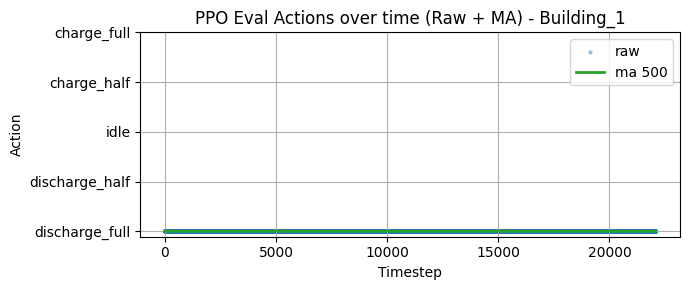

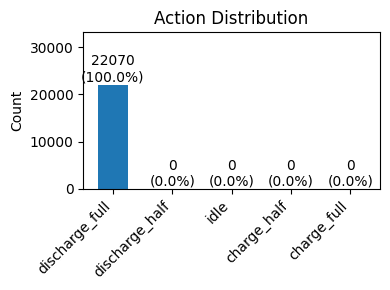

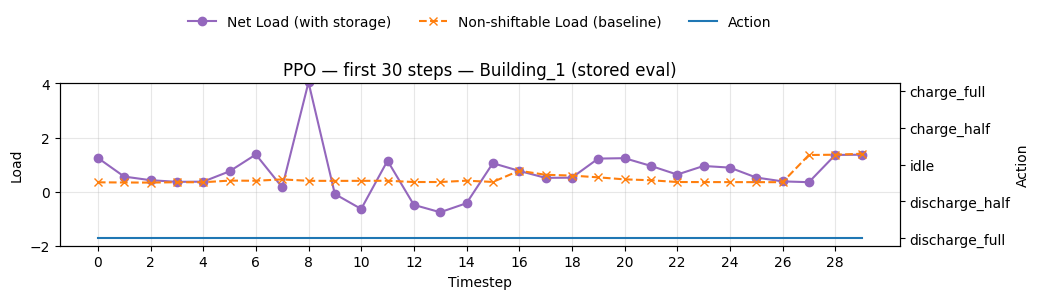

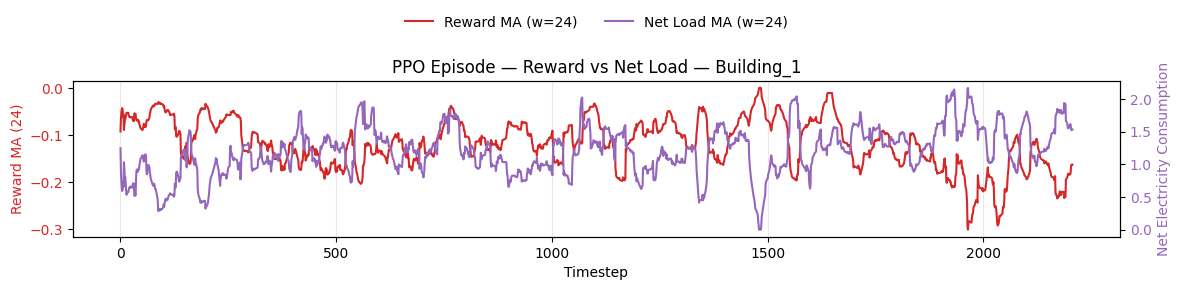

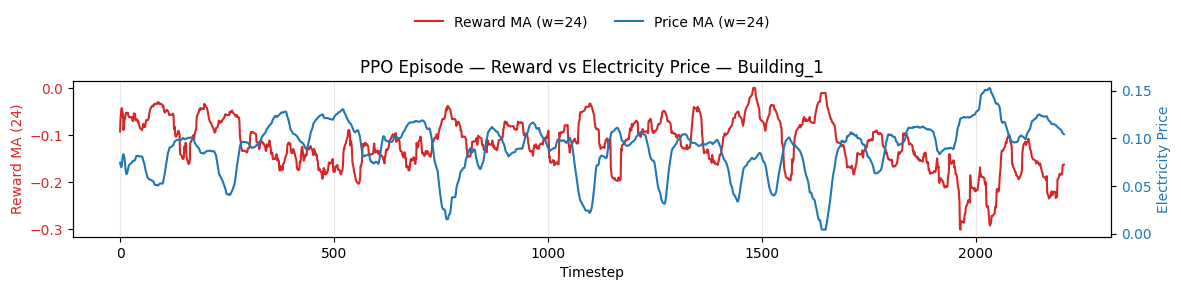

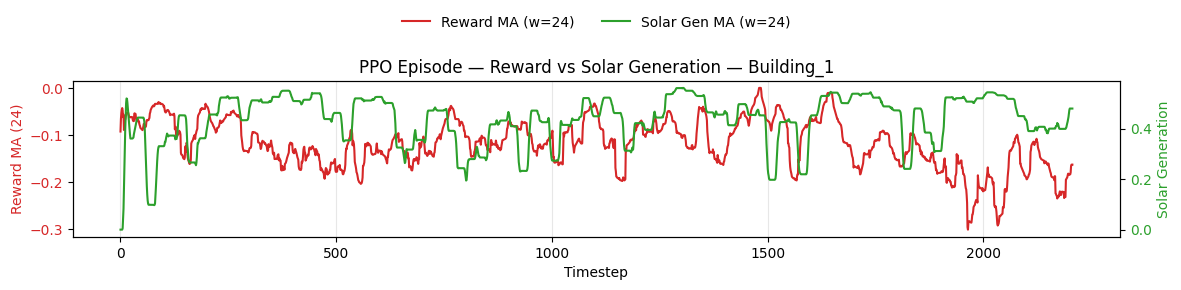

In [20]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
from citylearn.citylearn import CityLearnEnv
from matplotlib.ticker import MultipleLocator
import pickle

def _ensure_ppo_eval_results(path=EVAL_FILE):
    """Return cached PPO eval results if present; else load from file."""
    global er_ppo
    if 'er_ppo' in globals() and isinstance(er_ppo, dict):
        return er_ppo
    if os.path.exists(path):
        with open(path, "rb") as f:
            er_ppo = pickle.load(f)
        print(f"PPO eval results loaded from {os.path.abspath(path)}.")
        return er_ppo
    raise FileNotFoundError(f"{path} not found. Run evaluate_with_metrics(..., save_path=EVAL_FILE) first.")

# Load saved PPO eval
er = _ensure_ppo_eval_results()

# Rebuild actions_det and metrics_det from file (like A2C)
if 'ep_action_fracs' in er:
    actions_det = [np.asarray(ep, dtype=float)[:, None] for ep in er['ep_action_fracs']]
elif 'actions_disc_list' in er:
    actions_det = [INT_TO_FRAC[np.asarray(ep, dtype=int)][:, None] for ep in er['actions_disc_list']]
else:
    raise KeyError("No action sequences found in PPO eval results.")

metrics_det = er.get('metrics_df', None)
if metrics_det is None or not isinstance(metrics_det, pd.DataFrame):
    ep_lengths = np.asarray(er.get('ep_lengths', [len(x) for x in actions_det]), dtype=int)
    metrics_det = pd.DataFrame({'episode': np.arange(1, len(ep_lengths)+1), 'length': ep_lengths})

# Prefer building name from file if present
building_name = er.get('building_name', 'Building_1')

# Choose a building to visualize
bld_names = [b.name for b in eval_env.unwrapped.buildings]
if building_name not in bld_names:
    building_name = bld_names[0]
b_idx = bld_names.index(building_name)
print(f'Plotting actions for building: {building_name} (index {b_idx})')

# Flatten evaluated actions across episodes -> shape (total_steps, n_actions)
actions_arr = np.concatenate(actions_det, axis=0)  # each item shape (ep_len, n_actions)
n_actions = actions_arr.shape[1]
total_steps = actions_arr.shape[0]

# Build episode boundaries from metrics
ep_lengths = metrics_det['length'].to_numpy()
ep_offsets = np.cumsum(np.concatenate([[0], ep_lengths[:-1]]))
hour_index = np.arange(total_steps)

# Load pricing for the chosen building
price_file = schema['buildings'][building_name]['pricing']
price_path = os.path.join(ROOT_DIR, price_file)
prc = pd.read_csv(price_path)
T = len(prc)  # usually 2208

# Helper: map continuous action to 5 RBC-like labels by nearest of [-1,-0.5,0,0.5,1]
bin_centers = np.array([-1.0, -0.5, 0.0, 0.5, 1.0])
def cont_to_label(vals):
    idx = np.argmin(np.abs(vals[..., None] - bin_centers[None, ...]), axis=-1)
    return idx  # 0..4

# ----- Plot 1: Actions over Time (for selected building) -----
window = 500
act_series = actions_arr[:, b_idx]
act_ma = pd.Series(act_series).rolling(window, min_periods=1).mean().to_numpy()

plt.figure(figsize=(7,3))
plt.scatter(hour_index, act_series, s=5, alpha=0.35, label='raw')
plt.plot(hour_index, act_ma, color='C2', lw=2, label=f'ma {window}')
plt.title(f'PPO Eval Actions over time (Raw + MA) - {building_name}')
plt.xlabel('Timestep'); plt.ylabel('Action'); plt.grid(True); plt.legend(loc='upper right')
plt.yticks(ticks=INT_TO_FRAC.tolist(), labels=ACTION_LABELS)
plt.tight_layout(); plt.show()

# ----- Plot 2: Action Distribution (quantized to 5 bins like RBC) -----
plt.figure(figsize=(4,3))
labels_idx = cont_to_label(act_series)
counts = pd.Series(labels_idx).value_counts().reindex(range(5)).fillna(0).astype(int)
ax = counts.plot(kind='bar', color=['C0','C1','C2','C3','C4'])
ax.set_xticklabels(ACTION_LABELS, rotation=45, ha='right')
total = counts.sum()
ax.bar_label(ax.containers[0], labels=[f'{int(v)}\n({v/total:.1%})' for v in counts.values])
ax.set_ylim(0, counts.max()*1.5)
plt.ylabel('Count'); plt.title('Action Distribution'); plt.tight_layout(); plt.show()


def unwrap_to_citylearn(env):
    cur, seen = env, set()
    while cur is not None and id(cur) not in seen:
        seen.add(id(cur))
        if isinstance(cur, CityLearnEnv):
            return cur
        cur = getattr(cur, "env", getattr(cur, "unwrapped", None))
    raise RuntimeError("CityLearnEnv not found inside wrappers.")

def add_top_legend(ax_left, ax_right=None, ncol=3, y=1.50, top=0.84, loc='upper center', frameon=False):
    """Place a combined legend above the plot using lines from one or two axes."""
    handles = []
    for ax in (ax_left, ax_right):
        if ax is None:
            continue
        handles.extend(ax.get_lines())
    labels = [h.get_label() for h in handles]
    legend = ax_left.legend(handles, labels, loc=loc, bbox_to_anchor=(0.5, y), ncol=ncol, frameon=frameon)
    if top is not None:
        plt.subplots_adjust(top=top)
    return legend

def capture_ep_series_ppo(building_name="Building_1", episode_idx=0, max_steps=None):
    """Build per-step DataFrame from saved PPO eval_results; no env stepping."""
    er = _ensure_ppo_eval_results()
    needed = ['ep_action_fracs','ep_rewards_list','ep_net_load','ep_non_shiftable_load','ep_price','ep_solar_generation']
    missing = [k for k in needed if k not in er]
    if missing:
        raise ValueError(f"ppo eval_results missing keys: {missing}. Re-run evaluate_with_metrics to regenerate.")
    n_eps = len(er['ep_rewards_list'])
    if not (0 <= episode_idx < n_eps):
        raise IndexError(f"episode_idx {episode_idx} out of range 0..{n_eps-1}")

    if 'actions_disc_list' in er and er['actions_disc_list'] and len(er['actions_disc_list']) > episode_idx:
        a_id = np.asarray(er['actions_disc_list'][episode_idx], dtype=int)
    else:
        frac = np.asarray(er['ep_action_fracs'][episode_idx], dtype=float)
        a_id = np.argmin(np.abs(frac[:, None] - INT_TO_FRAC[None, :]), axis=1)

    a_frac = np.asarray(er['ep_action_fracs'][episode_idx], dtype=float)
    rew    = np.asarray(er['ep_rewards_list'][episode_idx], dtype=float)
    net    = np.asarray(er['ep_net_load'][episode_idx], dtype=float)
    nsl    = np.asarray(er['ep_non_shiftable_load'][episode_idx], dtype=float)
    price  = np.asarray(er['ep_price'][episode_idx], dtype=float)
    solar  = np.asarray(er['ep_solar_generation'][episode_idx], dtype=float)
    L = len(rew)
    if max_steps is not None:
        L = min(L, int(max_steps))
        a_id, a_frac, rew, net, nsl, price, solar = (
            a_id[:L], a_frac[:L], rew[:L], net[:L], nsl[:L], price[:L], solar[:L]
        )
    df = pd.DataFrame({
        't': np.arange(L, dtype=int),
        'action_id': a_id,
        'action_frac': a_frac,
        'reward': rew,
        'net_load': net,
        'non_shiftable_load': nsl,
        'price': price,
        'solar_generation': solar,
    })
    return df, er.get('building_name', building_name)

def plot_first_30_steps_actions_vs_loads_ppo(building_name="Building_1", episode_idx=0):
    """Plot first 30 steps using stored eval."""
    df30, bname = capture_ep_series_ppo(building_name, episode_idx=episode_idx, max_steps=30)
    t = df30['t'].to_numpy()
    net = df30['net_load'].to_numpy()
    nsl = df30['non_shiftable_load'].to_numpy()
    act = df30['action_frac'].to_numpy()

    fig, ax1 = plt.subplots(figsize=(10.5, 3.6))
    ax1.plot(t, net, color='C4', marker='o', label='Net Load (with storage)')
    ax1.plot(t, nsl, color='C1', ls='--', marker='x', label='Non-shiftable Load (baseline)')
    ax1.set_xlabel('Timestep')
    ax1.set_xticks(t[::2])
    ax1.set_ylabel('Load')
    ax1.set_ylim(-2, 4)
    ax1.yaxis.set_major_locator(MultipleLocator(2))
    ax1.grid(True, alpha=0.3)

    ax2 = ax1.twinx()
    ax2.step(t, act, where='mid', color='C0', label='Action')
    ax2.set_ylabel('Action')
    ax2.set_ylim(-1.1, 1.1)
    ax2.set_yticks(INT_TO_FRAC.tolist())
    try:
        ax2.set_yticklabels(ACTION_LABELS)
    except Exception:
        ax2.set_yticklabels(['discharge_full', 'discharge_half', 'idle', 'charge_half', 'charge_full'])
    add_top_legend(ax1, ax2)
    plt.title(f'PPO — first 30 steps — {bname} (stored eval)')
    plt.tight_layout()
    plt.show()

def plot_ep1_reward_vs_obs_ppo(building_name="Building_1", episode_idx=0):
    """Three plots using stored eval for selected episode."""
    df, bname = capture_ep_series_ppo(building_name, episode_idx=episode_idx, max_steps=None)
    window_reward = 24
    window_x = 24
    t = df['t'].to_numpy()
    reward_ma = pd.Series(df['reward']).rolling(window_reward, min_periods=1).mean().to_numpy()
    price_ma  = pd.Series(df['price']).rolling(window_x, min_periods=1).mean().to_numpy()
    solar_ma  = pd.Series(df['solar_generation']).rolling(window_x, min_periods=1).mean().to_numpy()
    net_ma    = pd.Series(df['net_load']).rolling(window_x, min_periods=1).mean().to_numpy()

    fig, ax1 = plt.subplots(figsize=(12, 3.5))
    ax1.plot(t, reward_ma, color='C3', label=f'Reward MA (w={window_reward})')
    ax1.set_xlabel('Timestep'); ax1.set_ylabel(f'Reward MA ({window_reward})', color='C3')
    ax1.tick_params(axis='y', labelcolor='C3'); ax1.grid(True, axis='x', alpha=0.3)
    ax2 = ax1.twinx()
    ax2.plot(t, net_ma, color='C4', label=f'Net Load MA (w={window_x})')
    ax2.set_ylabel('Net Electricity Consumption', color='C4'); ax2.tick_params(axis='y', labelcolor='C4')
    add_top_legend(ax1, ax2)
    ax1.set_title(f'PPO Episode — Reward vs Net Load — {bname}')
    plt.tight_layout(); plt.show()

    fig, ax1 = plt.subplots(figsize=(12, 3.5))
    ax1.plot(t, reward_ma, color='C3', label=f'Reward MA (w={window_reward})')
    ax1.set_xlabel('Timestep'); ax1.set_ylabel(f'Reward MA ({window_reward})', color='C3')
    ax1.tick_params(axis='y', labelcolor='C3'); ax1.grid(True, axis='x', alpha=0.3)
    ax2 = ax1.twinx()
    ax2.plot(t, price_ma, color='C0', label=f'Price MA (w={window_x})')
    ax2.set_ylabel('Electricity Price', color='C0'); ax2.tick_params(axis='y', labelcolor='C0')
    add_top_legend(ax1, ax2)
    ax1.set_title(f'PPO Episode — Reward vs Electricity Price — {bname}')
    plt.tight_layout(); plt.show()

    fig, ax1 = plt.subplots(figsize=(12, 3.5))
    ax1.plot(t, reward_ma, color='C3', label=f'Reward MA (w={window_reward})')
    ax1.set_xlabel('Timestep'); ax1.set_ylabel(f'Reward MA ({window_reward})', color='C3')
    ax1.tick_params(axis='y', labelcolor='C3'); ax1.grid(True, axis='x', alpha=0.3)
    ax2 = ax1.twinx()
    ax2.plot(t, solar_ma, color='C2', label=f'Solar Gen MA (w={window_x})')
    ax2.set_ylabel('Solar Generation', color='C2'); ax2.tick_params(axis='y', labelcolor='C2')
    add_top_legend(ax1, ax2)
    ax1.set_title(f'PPO Episode — Reward vs Solar Generation — {bname}')
    plt.tight_layout(); plt.show()

# ----- Plot 3: Actions vs Loads (first 30 steps) from file -----
plot_first_30_steps_actions_vs_loads_ppo(building_name=building_name, episode_idx=0)

# ----- Plot 4,5,6: Reward vs Observations (stored eval) -----
plot_ep1_reward_vs_obs_ppo(building_name=building_name, episode_idx=0)

In [10]:
# Quick action-distribution sanity check (quantize to 5 bins)
import pickle, pandas as pd, numpy as np
er = _ensure_ppo_eval_results(path=EVAL_FILE)
if 'ep_action_fracs' in er:
    a = np.concatenate([np.asarray(ep) for ep in er['ep_action_fracs']])
    bins = np.array([-1.0, -0.5, 0.0, 0.5, 1.0], dtype=float)
    idx = np.argmin(np.abs(a[:, None] - bins[None, :]), axis=1)
    dist = pd.Series(idx).value_counts().reindex(range(5)).fillna(0).astype(int)
    total = dist.sum()
    print('PPO action distribution (bin 0..4):', dist.to_dict())
    print('PPO action distribution pct:', {i: f'{int(v)} ({v/total:.1%})' for i,v in dist.items()})
else:
    print("No 'ep_action_fracs' in eval results; check evaluate_with_metrics output.")

PPO action distribution (bin 0..4): {0: 22070, 1: 0, 2: 0, 3: 0, 4: 0}
PPO action distribution pct: {0: '22070 (100.0%)', 1: '0 (0.0%)', 2: '0 (0.0%)', 3: '0 (0.0%)', 4: '0 (0.0%)'}


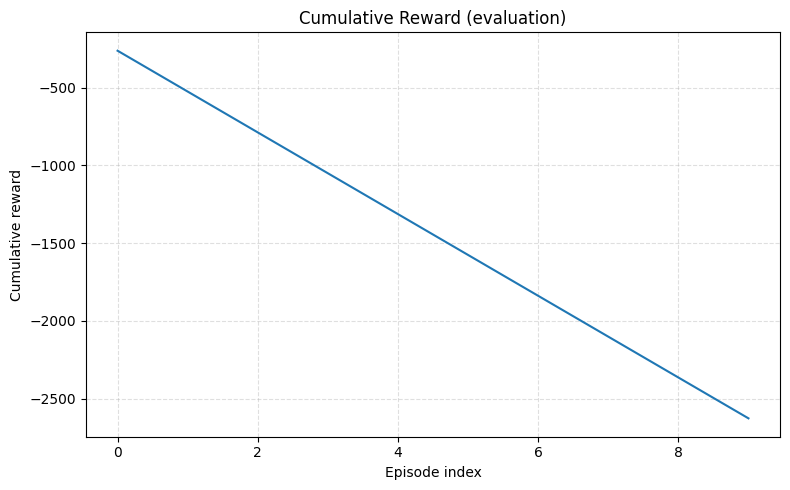

Episodes: 10 | Final cumulative reward: -2626.958


In [ ]:
# Plot cumulative reward from DQN eval .pkl
# Uses keys present in: 'ep_rewards_list'
# falls back to ('step_rewards' + 'ep_lengths') if needed.

import os
import pickle
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

p = Path(EVAL_FILE)
if not p.exists():
    raise FileNotFoundError(f"Eval file not found: {p.resolve()}")

with open(p, "rb") as f:
    data = pickle.load(f)

def to_1d_float_array(x):
    arr = np.asarray(x, dtype=float)
    return arr.ravel()

def extract_episode_returns(d):
    # Preferred: ep_rewards_list
    if isinstance(d, dict) and "ep_rewards_list" in d:
        ep = d["ep_rewards_list"]
        # ep can be: list[float] OR list[list[step_rewards]]/ndarrays
        if len(ep) == 0:
            return np.array([], dtype=float)
        first = ep[0]
        if isinstance(first, (list, tuple, np.ndarray)):
            # list of per-step rewards per episode -> sum each episode
            return np.array([np.sum(np.asarray(e, dtype=float)) for e in ep], dtype=float)
        else:
            # already per-episode returns
            return to_1d_float_array(ep)

    # Fallback: step_rewards segmented by ep_lengths
    if isinstance(d, dict) and "step_rewards" in d and "ep_lengths" in d:
        step_rewards = to_1d_float_array(d["step_rewards"])
        ep_lengths = np.asarray(d["ep_lengths"], dtype=int).ravel()
        if np.sum(ep_lengths) != step_rewards.size:
            raise ValueError(
                f"Mismatch: sum(ep_lengths)={np.sum(ep_lengths)} != len(step_rewards)={step_rewards.size}"
            )
        # segment
        offsets = np.cumsum(np.concatenate([[0], ep_lengths[:-1]]))
        returns = [step_rewards[o:o+l].sum() for o, l in zip(offsets, ep_lengths)]
        return np.asarray(returns, dtype=float)

    # 3) Very last resort: common keys
    for k in ["episode_rewards", "returns", "reward", "return"]:
        if isinstance(d, dict) and k in d:
            return to_1d_float_array(d[k])

    raise ValueError(
        "Could not extract per-episode returns. "
        "Expected 'ep_rewards_list' or ('step_rewards' + 'ep_lengths'). "
        f"Available keys: {list(d.keys()) if isinstance(d, dict) else type(d)}"
    )

episode_returns = extract_episode_returns(data)
print(episode_returns)
if episode_returns.size == 0:
    raise ValueError("No episodes found in eval results (empty returns).")

cumulative = np.cumsum(episode_returns)

# Plot cumulative
plt.figure(figsize=(8, 5))
plt.plot(cumulative)
plt.xlabel("Episode index")
plt.ylabel("Cumulative reward")
plt.title("Cumulative Reward (evaluation)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

print(f"Episodes: {episode_returns.size} | Final cumulative reward: {cumulative[-1]:.3f}")

Episodes available (per env):
    env_id  episode  steps
0        0        0   2207
1        0        1   2207
2        0        2   2207
3        0        3   2207
4        0        4   2207
5        0        5   2207
6        0        6   2207
7        0        7   2207
8        0        8   2207
9        0        9   2207
10       0       10   2207
11       0       11   2207
12       0       12   2207
13       0       13   2207
14       0       14   2207
15       0       15   2207
16       0       16   2207
17       0       17   2207
18       0       18   2207
19       0       19   2207
Plotting env_id=0, episode=0


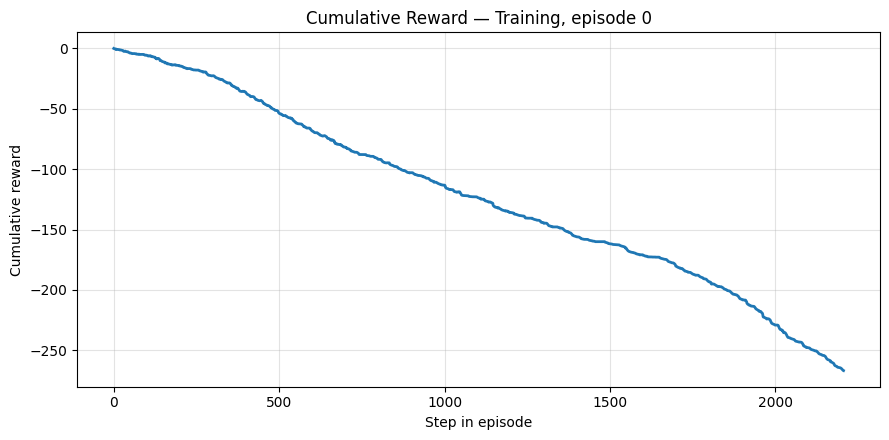

Episode length: 2207 steps | Return: -266.775


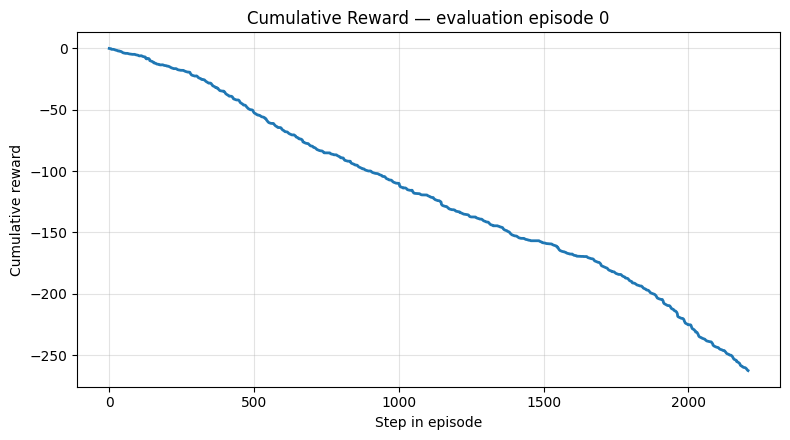

Episode 0 length: 2207 steps | Return: -262.696


In [30]:
# === Plot cumulative reward for ONE episode from TRAIN_STEPS_FILE ===
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Einstellungen: welche Env/Episode plotten?
ENV_ID = 0            # bei DummyVecEnv meist 0
EPISODE_IDX = 0      # -1 = letzte gefüllte Episode dieses ENV_ID, sonst z.B. 0,1,2,...

# 2) CSV laden
csv_path = TRAIN_STEPS_FILE  # z.B. os.path.join(LOG_DIR, "ppo_train_steps_01.csv")
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"TRAIN_STEPS_FILE not found: {csv_path}")

df = pd.read_csv(csv_path)

# Robust: Spalten-Typen säubern
for col in ("reward", "env_id", "episode", "global_step"):
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")
# Nur gültige Zeilen behalten
need_cols = [c for c in ("env_id", "episode", "reward") if c in df.columns]
df = df.dropna(subset=need_cols)

# 3) Episoden-Übersicht je Env ausgeben
episodes_per_env = (
    df.groupby(["env_id", "episode"], as_index=False)["reward"]
      .size()
      .rename(columns={"size": "steps"})
      .sort_values(["env_id", "episode"])
)
print("Episodes available (per env):")
print(episodes_per_env.head(20))

# 4) Eine Episode wählen
env_mask = (df["env_id"] == ENV_ID) if "env_id" in df.columns else np.ones(len(df), dtype=bool)
df_env = df.loc[env_mask].copy()
if "episode" not in df_env.columns:
    raise KeyError("CSV has no 'episode' column; cannot segment by episode.")

episodes = sorted(df_env["episode"].dropna().astype(int).unique())
if not episodes:
    raise ValueError(f"No episodes found for env_id={ENV_ID} in {csv_path}")

ep_chosen = episodes[EPISODE_IDX] if EPISODE_IDX != -1 else episodes[-1]
print(f"Plotting env_id={ENV_ID}, episode={ep_chosen}")

# 5) Daten der gewählten Episode in zeitlicher Reihenfolge
order_cols = ["global_step"] if "global_step" in df_env.columns else None
df_ep = df_env.loc[df_env["episode"] == ep_chosen].copy()
if order_cols:
    df_ep = df_ep.sort_values(order_cols)

# 6) kumulierten Reward berechnen
df_ep["reward"] = pd.to_numeric(df_ep["reward"], errors="coerce").fillna(0.0)
df_ep["cum_reward"] = df_ep["reward"].cumsum()
df_ep["t_in_ep"] = np.arange(len(df_ep), dtype=int)

# 7) Plot
plt.figure(figsize=(9, 4.5))
plt.plot(df_ep["t_in_ep"], df_ep["cum_reward"], lw=2)
plt.title(f"Cumulative Reward — Training, episode {ep_chosen}")
plt.xlabel("Step in episode")
plt.ylabel("Cumulative reward")
plt.grid(True, alpha=0.35)
plt.tight_layout()
plt.show()

print(f"Episode length: {len(df_ep)} steps | Return: {df_ep['cum_reward'].iloc[-1]:.3f}")


# === Cumulative reward over timesteps for the FIRST evaluation episode (from EVAL_FILE .pkl) ===
import os, pickle
import numpy as np
import matplotlib.pyplot as plt

assert 'EVAL_FILE' in globals(), "EVAL_FILE is not defined."
if not os.path.exists(EVAL_FILE):
    raise FileNotFoundError(f"Eval file not found: {os.path.abspath(EVAL_FILE)}")

with open(EVAL_FILE, "rb") as f:
    er = pickle.load(f)

def _as_1d_float(x):
    return np.asarray(x, dtype=float).ravel()

def first_episode_step_rewards(data):
    """
    Try common layouts produced by your notebooks:
      - 'ep_rewards_list': list of per-episode step-reward arrays/lists
      - ('step_rewards' + 'ep_lengths'): flat step rewards + per-episode lengths
    Returns: np.ndarray of step rewards for episode 0.
    """
    if isinstance(data, dict):
        # Preferred: list of step-reward sequences per episode
        if "ep_rewards_list" in data and len(data["ep_rewards_list"]) > 0:
            ep0 = data["ep_rewards_list"][0]
            # Some pipelines store floats (already per-episode sum) -> then we can't do cumulative steps
            if isinstance(ep0, (list, tuple, np.ndarray)):
                return _as_1d_float(ep0)

        # Fallback: flat step_rewards segmented by ep_lengths
        if "step_rewards" in data and "ep_lengths" in data:
            step_rewards = _as_1d_float(data["step_rewards"])
            ep_lengths   = np.asarray(data["ep_lengths"], dtype=int).ravel()
            if ep_lengths.size == 0:
                raise ValueError("ep_lengths is empty in eval file.")
            L0 = int(ep_lengths[0])
            if L0 <= 0:
                raise ValueError(f"First episode length is non-positive: {L0}")
            if step_rewards.size < L0:
                raise ValueError(f"Not enough step rewards for first episode: have {step_rewards.size}, need {L0}")
            return step_rewards[:L0]

        # Some variants:
        for k in ("episode_step_rewards", "rewards_per_step", "ep0_step_rewards"):
            if k in data:
                return _as_1d_float(data[k])

    raise ValueError(
        "Could not find per-step rewards for episode 0 in EVAL_FILE. "
        "Expected 'ep_rewards_list' (list of per-step arrays) or ('step_rewards' + 'ep_lengths'). "
        f"Available keys: {list(data.keys()) if isinstance(data, dict) else type(data)}"
    )

# Extract per-step rewards for first eval episode
r0 = first_episode_step_rewards(er)
cum0 = np.cumsum(r0)

# Plot
plt.figure(figsize=(8, 4.5))
plt.plot(np.arange(len(cum0)), cum0, lw=2)
plt.title("Cumulative Reward — evaluation episode 0")
plt.xlabel("Step in episode")
plt.ylabel("Cumulative reward")
plt.grid(True, alpha=0.35)
plt.tight_layout()
plt.show()

print(f"Episode 0 length: {len(r0)} steps | Return: {cum0[-1]:.3f}")



In [31]:
# === Min/Max aus Pricing-CSV ===
import os
import pandas as pd
import numpy as np

PRICING_FILE = 'pricing_germany_2023_june_to_august.csv'  # ggf. schon gesetzt
# Falls du ROOT_DIR in deinem Notebook nutzt:
try:
    pricing_path = os.path.join(ROOT_DIR, PRICING_FILE)
except NameError:
    pricing_path = PRICING_FILE

if not os.path.exists(pricing_path):
    raise FileNotFoundError(f"Pricing file not found: {os.path.abspath(pricing_path)}")

df = pd.read_csv(pricing_path)

# Mögliche Spaltennamen (anpassen falls nötig)
candidates = [
    'electricity_pricing'
]
price_col = None
for c in candidates:
    if c in df.columns:
        price_col = c
        break
# Wenn nix passt, versuch eine einzelne numerische Spalte zu finden
if price_col is None:
    numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    if len(numeric_cols) == 1:
        price_col = numeric_cols[0]
    else:
        raise ValueError(f"Keine eindeutige Preis-Spalte gefunden. Spalten: {list(df.columns)}")

series = pd.to_numeric(df[price_col], errors='coerce').dropna()
print(f"Pricing file: {os.path.abspath(pricing_path)}")
print(f"Spalte: '{price_col}' | Werte: {len(series)}")

print(f"Min : {series.min():.6f}")
print(f"Max : {series.max():.6f}")
print(f"Mittelwert : {series.mean():.6f}")
print(f"Median     : {series.median():.6f}")


Pricing file: /hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/pricing_germany_2023_june_to_august.csv
Spalte: 'electricity_pricing' | Werte: 2208
Min : -0.500000
Max : 0.291930
Mittelwert : 0.088831
Median     : 0.094620


In [32]:
# === Min/Max von net_load aus TRAIN_STEPS_FILE ===
import os
import pandas as pd
import numpy as np

assert 'TRAIN_STEPS_FILE' in globals(), "TRAIN_STEPS_FILE ist nicht definiert."
if not os.path.exists(TRAIN_STEPS_FILE):
    raise FileNotFoundError(f"Datei nicht gefunden: {os.path.abspath(TRAIN_STEPS_FILE)}")

df = pd.read_csv(TRAIN_STEPS_FILE)

if 'net_load' not in df.columns:
    raise KeyError(f"'net_load' nicht in Spalten: {list(df.columns)[:10]} ...")

net = pd.to_numeric(df['net_load'], errors='coerce').dropna()

print(f"Datei: {os.path.abspath(TRAIN_STEPS_FILE)}")
print(f"Anzahl gültiger net_load-Werte: {len(net)}")
print(f"Min  : {net.min():.6f}")
print(f"Max  : {net.max():.6f}")
print(f"Mittelwert: {net.mean():.6f}")
print(f"Median    : {net.median():.6f}")

# Optional: pro env_id ausgeben (falls vorhanden)
if 'env_id' in df.columns:
    by_env = (pd.DataFrame({'net_load': net})
              .join(df.loc[net.index, 'env_id'].reset_index(drop=True))
              .groupby('env_id')['net_load'])
    print("\nPro env_id:")
    for eid, s in by_env:
        print(f"  env {eid}: min={s.min():.6f}, max={s.max():.6f}, n={s.size}")


Datei: /hkfs/home/haicore/iai/cj9272/logs/ppo/ppo_train_steps_01.csv
Anzahl gültiger net_load-Werte: 110400
Min  : -2.897844
Max  : 11.903888
Mittelwert: 1.217221
Median    : 0.974368

Pro env_id:
  env 0: min=-2.897844, max=11.903888, n=110400


In [33]:
# === Min/Max von reward aus TRAIN_STEPS_FILE ===
import os
import pandas as pd
import numpy as np

assert 'TRAIN_STEPS_FILE' in globals(), "TRAIN_STEPS_FILE ist nicht definiert."
if not os.path.exists(TRAIN_STEPS_FILE):
    raise FileNotFoundError(f"Datei nicht gefunden: {os.path.abspath(TRAIN_STEPS_FILE)}")

df = pd.read_csv(TRAIN_STEPS_FILE)

if 'reward' not in df.columns:
    raise KeyError(f"'reward' nicht in Spalten: {list(df.columns)[:10]} ...")

rew = pd.to_numeric(df['reward'], errors='coerce').dropna()

print(f"Datei: {os.path.abspath(TRAIN_STEPS_FILE)}")
print(f"Anzahl gültiger reward-Werte: {len(rew)}")
print(f"Min  : {rew.min():.6f}")
print(f"Max  : {rew.max():.6f}")
print(f"Mittelwert: {rew.mean():.6f}")
print(f"Median    : {rew.median():.6f}")

# Optional: pro env_id ausgeben (falls vorhanden)
if 'env_id' in df.columns:
    by_env = (pd.DataFrame({'reward': rew})
              .join(df.loc[rew.index, 'env_id'].reset_index(drop=True))
              .groupby('env_id')['reward'])
    print("\nPro env_id:")
    for eid, s in by_env:
        print(f"  env {eid}: min={s.min():.6f}, max={s.max():.6f}, n={s.size}")


Datei: /hkfs/home/haicore/iai/cj9272/logs/ppo/ppo_train_steps_01.csv
Anzahl gültiger reward-Werte: 110400
Min  : -2.205978
Max  : 0.267832
Mittelwert: -0.119414
Median    : -0.084363

Pro env_id:
  env 0: min=-2.205978, max=0.267832, n=110400


In [35]:
# === Min/Max von non_shiftable_load aus TRAIN_STEPS_FILE ===
import os
import pandas as pd
import numpy as np

assert 'TRAIN_STEPS_FILE' in globals(), "TRAIN_STEPS_FILE ist nicht definiert."
if not os.path.exists(TRAIN_STEPS_FILE):
    raise FileNotFoundError(f"Datei nicht gefunden: {os.path.abspath(TRAIN_STEPS_FILE)}")

df = pd.read_csv(TRAIN_STEPS_FILE)

if 'non_shiftable_load' not in df.columns:
    raise KeyError(f"'non_shiftable_load' nicht in Spalten: {list(df.columns)[:10]} ...")

stor = pd.to_numeric(df['non_shiftable_load'], errors='coerce').dropna()

print(f"Datei: {os.path.abspath(TRAIN_STEPS_FILE)}")
print(f"Anzahl gültiger non_shiftable_load-Werte: {len(stor)}")
print(f"Min  : {stor.min():.6f}")
print(f"Max  : {stor.max():.6f}")
print(f"Mittelwert: {stor.mean():.6f}")
print(f"Median    : {stor.median():.6f}")

# Optional: pro env_id ausgeben (falls vorhanden)
if 'env_id' in df.columns:
    by_env = (pd.DataFrame({'non_shiftable_load': stor})
              .join(df.loc[stor.index, 'env_id'].reset_index(drop=True))
              .groupby('env_id')['non_shiftable_load'])
    print("\nPro env_id:")
    for eid, s in by_env:
        print(f"  env {eid}: min={s.min():.6f}, max={s.max():.6f}, n={s.size}")


Datei: /hkfs/home/haicore/iai/cj9272/logs/ppo/ppo_train_steps_01.csv
Anzahl gültiger non_shiftable_load-Werte: 110400
Min  : 0.000000
Max  : 7.458969
Mittelwert: 0.597131
Median    : 0.403018

Pro env_id:
  env 0: min=0.000000, max=7.458969, n=110400


#### Heatmap

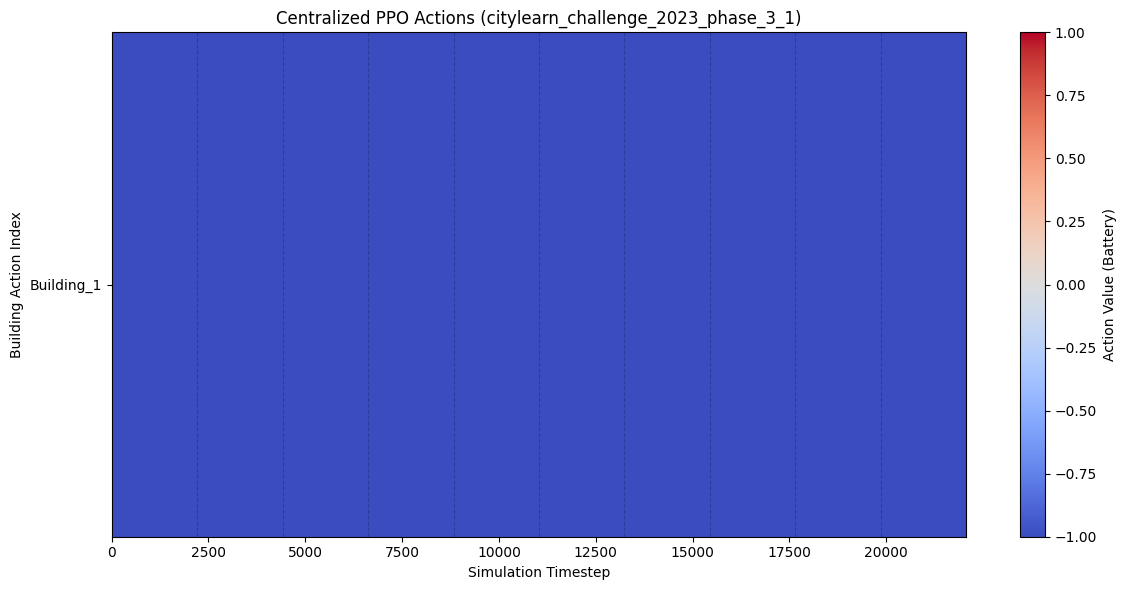

In [14]:
# Heatmap of centralized PPO actions across buildings and timesteps (eval episodes concatenated)
import os
import numpy as np
import matplotlib.pyplot as plt

# Require evaluated actions
assert 'actions_det' in globals() and len(actions_det) > 0, "Run evaluate_with_metrics first."

# Flatten list[(ep_len, n_actions)] -> (total_steps, n_actions)
actions_arr = np.concatenate(actions_det, axis=0)
n_steps, n_actions = actions_arr.shape

# Episode boundaries for vertical lines
ep_lengths = metrics_det['length'].to_numpy() if 'metrics_det' in globals() else np.array([n_steps])
ep_offsets = np.cumsum(np.concatenate([[0], ep_lengths[:-1]]))

# Building labels
bld_names = [b.name for b in eval_env.unwrapped.buildings]
if len(bld_names) != n_actions:
    bld_names = [f'Act {i}' for i in range(n_actions)]

# Output dir
results_dir = os.path.join(os.getcwd(), 'results')
os.makedirs(results_dir, exist_ok=True)

plt.figure(figsize=(12, 6))
plt.imshow(actions_arr.T, aspect='auto', interpolation='none', cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Action Value (Battery)')
plt.xlabel('Simulation Timestep')
plt.ylabel('Building Action Index')
plt.yticks(np.arange(n_actions), bld_names)

# Mark episode boundaries
for off in ep_offsets[1:]:
    plt.axvline(off, color='k', ls='--', lw=0.8, alpha=0.2)

plt.title(f'Centralized PPO Actions ({DATASET_NAME})')
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'ppo_actions_heatmap.png'), dpi=150)
plt.show()

#### DecisionTree

In [15]:
# ===================== Decision-Tree-Surrogate (PPO/A2C/DQN) =====================
# Komplett zum Einfügen ins Notebook – keine externen Python-Dateien nötig.

from typing import Any, Dict, List, Optional, Sequence, Tuple
import os
import numpy as np
import pandas as pd

# sklearn
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# plotting
import matplotlib.pyplot as plt


# ---------- Hilfsfunktionen: API-Kompatibilität & Feature-Namen ----------

def _flatten_obs(obs: Any) -> Tuple[np.ndarray, List[str]]:
    """Observation (np.ndarray oder dict) -> (1D-Array, Feature-Namen)."""
    if isinstance(obs, dict):
        keys = sorted(obs.keys())
        parts, names = [], []
        for k in keys:
            v = np.asarray(obs[k]).ravel()
            parts.append(v)
            names += [f"{k}:{i}" for i in range(v.size)]
        flat = np.concatenate(parts) if parts else np.array([], dtype=float)
        return flat.astype(float), names
    arr = np.asarray(obs).ravel().astype(float)
    names = [f"x{i}" for i in range(arr.size)]
    return arr, names

def _maybe_env_obs_names(env, fallback: List[str]) -> List[str]:
    """Versucht Env-spezifische Observationsnamen (z. B. CityLearn) zu übernehmen."""
    try:
        names = getattr(getattr(env, 'unwrapped', env), 'observation_names', None)
        if isinstance(names, (list, tuple)) and len(names) > 0:
            if isinstance(names[0], (list, tuple)) and len(names[0]) == len(fallback):
                return list(names[0])
            if len(names) == len(fallback):
                return list(names)
    except Exception:
        pass
    return fallback

def _unwrap_reset(reset_out):
    """Gymnasium: (obs, info) -> obs | SB3 VecEnv/Gym: obs"""
    if isinstance(reset_out, tuple) and len(reset_out) >= 1:
        return reset_out[0]
    return reset_out

def _unwrap_step(step_out):
    """Normalisiert step()-Output auf (obs, rewards, dones, infos)."""
    if isinstance(step_out, tuple):
        if len(step_out) == 5:
            obs, reward, terminated, truncated, info = step_out
            done = np.asarray(terminated) | np.asarray(truncated)
            return obs, reward, done, info
        elif len(step_out) == 4:
            return step_out
    raise ValueError("Unerwartetes step()-Format")


# ---------- Datensammlung: Rollout oder (optional) Eval-PKL laden ----------
def collect_policy_dataset(
    model,
    env,
    n_steps: Optional[int] = 20000,
    n_episodes: Optional[int] = None,
    deterministic: bool = True,
    action_labels: Optional[Sequence[str]] = None,
    discretize_continuous: Optional[callable] = None,  # fn(action_vec)->int action_id
    progress: bool = True,
) -> Tuple[pd.DataFrame, List[str]]:
    """Rollout (Policy→Aktion) und baue DataFrame mit x0..xN + 'action' (+ 'action_label').
    Single-Env: reset() manuell bei done; VecEnv: SB3 übernimmt Auto-Reset.
    """
    obs = _unwrap_reset(env.reset())
    rows: List[Dict[str, Any]] = []
    feature_names: Optional[List[str]] = None

    steps = 0
    episodes = 0
    n_envs = getattr(env, 'num_envs', 1)

    while True:
        # Stopbedingungen
        if n_steps is not None and steps >= n_steps:
            break
        if n_episodes is not None and episodes >= n_episodes:
            break

        # Aktion vorhersagen
        action, _ = model.predict(obs, deterministic=deterministic)

        # Diskrete Aktion ableiten (bei kontinuierlicher Policy discretize_continuous übergeben)
        if discretize_continuous is not None:
            if n_envs > 1:
                action_ids = [int(discretize_continuous(a)) for a in np.asarray(action)]
            else:
                action_ids = [int(discretize_continuous(action))]
        else:
            if np.isscalar(action):
                action_ids = [int(action)]
            else:
                arr = np.asarray(action).reshape(-1)
                if arr.size >= 1 and np.all(np.equal(np.mod(arr, 1), 0)):
                    action_ids = [int(a) for a in arr]
                else:
                    raise ValueError("Aktion ist nicht diskret. Gib discretize_continuous=... an.")

        # Schritt ausführen (Gymnasium/VecEnv-kompatibel)
        obs_next, rewards, dones, infos = _unwrap_step(env.step(action))

        # Datenzeilen sammeln
        if n_envs == 1:
            flat, names = _flatten_obs(obs)
            if feature_names is None:
                feature_names = names
            row = {f"x{i}": flat[i] for i in range(len(flat))}
            row['action'] = action_ids[0]
            if action_labels is not None and 0 <= action_ids[0] < len(action_labels):
                row['action_label'] = str(action_labels[action_ids[0]])
            rows.append(row)

            # --- WICHTIG: Single-Env Reset bei done ---
            if bool(dones):
                episodes += 1
                obs = _unwrap_reset(env.reset())  # hier resetten, sonst off-by-one → IndexError
            else:
                obs = obs_next

        else:
            # VecEnv: Beobachtungen pro Env splitten, SB3 resetet intern automatisch
            if isinstance(obs, dict):
                keys = sorted(obs.keys())
                split_obs = [{k: np.asarray(obs[k])[e] for k in keys} for e in range(n_envs)]
            else:
                split_obs = [np.asarray(obs)[e] for e in range(n_envs)]

            for e in range(n_envs):
                flat, names = _flatten_obs(split_obs[e])
                if feature_names is None:
                    feature_names = names
                row = {f"x{i}": flat[i] for i in range(len(flat))}
                row['action'] = action_ids[e]
                if action_labels is not None and 0 <= action_ids[e] < len(action_labels):
                    row['action_label'] = str(action_labels[action_ids[e]])
                rows.append(row)

            # Episoden zählen (SB3 liefert bereits Reset-Obs in obs_next)
            dones_arr = np.asarray(dones).reshape(-1)
            episodes += int(np.sum(dones_arr))
            obs = obs_next

        steps += n_envs

        if progress and (steps % 5000 == 0):
            print(f"Collected ~{steps} steps...")

    df = pd.DataFrame(rows)
    if df.empty:
        raise RuntimeError("Kein Datensatz gesammelt. Prüfe env/model.")
    if feature_names is None:
        feature_names = [c for c in df.columns if c.startswith("x")]
    feature_names = _maybe_env_obs_names(env, feature_names)
    return df, feature_names

def load_dataset_from_eval_pkl(eval_pkl_path: str) -> Tuple[pd.DataFrame, List[str]]:
    """
    Optional: lädt ein eigenes .pkl-Format aus deinem Eval (z. B. DQN/A2C),
    und gibt (df[x*], feature_names) zurück. Versucht gängige Strukturen robust zu erkennen.
    """
    import pickle
    with open(eval_pkl_path, "rb") as f:
        data = pickle.load(f)

    # Heuristik 1: bereits ein DataFrame mit x*-Spalten
    if isinstance(data, pd.DataFrame) and any(c.startswith("x") for c in data.columns):
        feat_cols = sorted([c for c in data.columns if c.startswith("x")],
                           key=lambda c: int(c[1:]) if c[1:].isdigit() else 1_000_000)
        return data.copy(), feat_cols

    # Heuristik 2: Dict mit "steps" -> Liste von Dicts (die x0..xN + action enthalten)
    if isinstance(data, dict) and "steps" in data and isinstance(data["steps"], list):
        df = pd.DataFrame(data["steps"])
        if "action" not in df.columns:
            raise ValueError("Im .pkl fehlen 'action'-Labels.")
        feat_cols = sorted([c for c in df.columns if c.startswith("x")],
                           key=lambda c: int(c[1:]) if c[1:].isdigit() else 1_000_000)
        if not feat_cols:
            # Manche speichern 'obs' als Liste/Array – in Spalten aufklappen
            if "obs" in df.columns:
                obs_mat = np.vstack(df["obs"].to_numpy())
                feat_cols = [f"x{i}" for i in range(obs_mat.shape[1])]
                for i, col in enumerate(feat_cols):
                    df[col] = obs_mat[:, i]
            else:
                raise ValueError("Konnte keine Feature-Spalten im .pkl finden.")
        return df, feat_cols

    # Heuristik 3: Liste von Dicts
    if isinstance(data, list) and len(data) > 0 and isinstance(data[0], dict):
        df = pd.DataFrame(data)
        if "action" not in df.columns:
            raise ValueError("Im .pkl fehlen 'action'-Labels.")
        feat_cols = sorted([c for c in df.columns if c.startswith("x")],
                           key=lambda c: int(c[1:]) if c[1:].isdigit() else 1_000_000)
        if not feat_cols and "obs" in df.columns:
            obs_mat = np.vstack(df["obs"].to_numpy())
            feat_cols = [f"x{i}" for i in range(obs_mat.shape[1])]
            for i, col in enumerate(feat_cols):
                df[col] = obs_mat[:, i]
        return df, feat_cols

    raise ValueError("Unbekanntes .pkl-Format – gib mir kurz die Struktur, dann passe ich es an.")

def train_policy_tree(
    df: pd.DataFrame,
    action_labels: Optional[Sequence[str]] = None,
    feature_names: Optional[List[str]] = None,
    out_dir: str = "explain/ppo_tree",
    do_gridsearch: bool = True,
    max_depth: int = 4,
    min_samples_leaf: int = 50,
    random_state: int = 0
):
    """Trainiert DecisionTreeClassifier auf df[x*] -> df['action'] und exportiert Artefakte."""
    os.makedirs(out_dir, exist_ok=True)
    feat_cols = sorted(
        [c for c in df.columns if c.startswith('x')],
        key=lambda c: int(c[1:]) if c[1:].isdigit() else 1_000_000
    )
    if not feat_cols:
        raise ValueError("Keine Feature-Spalten (x0..xN) gefunden.")
    X = df[feat_cols].to_numpy()
    y = df['action'].astype(int).to_numpy()

    if feature_names is None:
        feature_names = feat_cols

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, stratify=y, random_state=random_state
    )

    if not do_gridsearch:
        clf = DecisionTreeClassifier(
            criterion='gini',
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            random_state=random_state,
            class_weight='balanced'
        )
        clf.fit(X_train, y_train)
        best_params = clf.get_params()
    else:
        param_grid = {
            'criterion': ['gini', 'entropy', 'log_loss'],
            'max_depth': [3, 4, 5, 6, None],
            'min_samples_leaf': [1, 5, 10, 25, 50],
            'min_samples_split': [2, 5, 10, 20],
            'class_weight': [None, 'balanced'],
            'ccp_alpha': [0.0, 0.0005, 0.001, 0.005],
            'splitter': ['best']
        }
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid = GridSearchCV(
            DecisionTreeClassifier(random_state=random_state),
            param_grid=param_grid,
            scoring='balanced_accuracy',
            cv=cv,
            n_jobs=-1,
            verbose=1
        )
        grid.fit(X_train, y_train)
        clf = grid.best_estimator_
        best_params = grid.best_params_

    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    try:
        report_txt = classification_report(
            y_test, y_pred, target_names=action_labels
        ) if action_labels is not None else classification_report(y_test, y_pred)
    except Exception:
        report_txt = classification_report(y_test, y_pred)

    # Regeln als Text
    rules_txt = export_text(clf, feature_names=feature_names)
    with open(os.path.join(out_dir, 'tree_rules.txt'), 'w') as f:
        f.write(rules_txt)

    # Graphviz bevorzugt, sonst PNG
    graph_path = None
    try:
        from sklearn.tree import export_graphviz
        import graphviz
        dot = export_graphviz(
            clf,
            out_file=None,
            feature_names=feature_names,
            class_names=action_labels if action_labels is not None else [str(i) for i in sorted(set(y))],
            filled=True,
            rounded=True,
            special_characters=True
        )
        g = graphviz.Source(dot)
        svg_base = os.path.join(out_dir, 'tree')
        g.render(svg_base, format='svg', cleanup=True)
        graph_path = svg_base + '.svg'
    except Exception:
        png_path = os.path.join(out_dir, 'tree_plot.png')
        plt.figure(figsize=(32, 16), dpi=200)
        plot_tree(
            clf,
            feature_names=feature_names,
            class_names=action_labels if action_labels is not None else [str(i) for i in sorted(set(y))],
            filled=True,
            rounded=True
        )
        plt.tight_layout()
        plt.savefig(png_path)
        plt.close()
        graph_path = png_path

    summary = (
        f"Surrogate Tree Accuracy: {acc:.3f}\n"
        f"Best params: {best_params}\n"
        f"Confusion matrix (rows=true, cols=pred):\n{cm}\n\n"
        f"Classification report:\n{report_txt}"
    )
    result = {
        'clf': clf,
        'feature_names': feature_names,
        'accuracy': float(acc),
        'best_params': best_params,
        'confusion_matrix': cm.tolist(),
        'classification_report': report_txt,
        'summary': summary,
        'rules_path': os.path.join(out_dir, 'tree_rules.txt'),
        'graph_path': graph_path
    }
    return clf, result


# ---------- Optional: Pfad-Erklärung für einzelne Samples ----------

def explain_sample_path(clf: DecisionTreeClassifier, feature_names: List[str], x_row: np.ndarray):
    """Gibt den Entscheidungs-Pfad (Feature, Wert, Threshold, Seite) für ein Sample zurück."""
    x = np.asarray(x_row).reshape(1, -1)
    tree = clf.tree_
    node = 0
    path = []
    while tree.feature[node] != -2:  # -2 = Leaf
        f_idx = tree.feature[node]
        thr = tree.threshold[node]
        val = float(x[0, f_idx])
        go_left = val <= thr
        path.append((feature_names[f_idx], val, thr, "left" if go_left else "right"))
        node = tree.children_left[node] if go_left else tree.children_right[node]
    return path

# ===================== Ende des Blocks =====================

In [23]:
# ca 25min
import os, json, time
from pathlib import Path
import pandas as pd
import joblib

# 1) Run-Ordner
run_dir = Path(LOG_DIR) / "explain_ppo_tree" / time.strftime("%Y-%m-%d_%H-%M-%S")
run_dir.mkdir(parents=True, exist_ok=True)

# 2) Dataset sammeln
df_tree, feat_names = collect_policy_dataset(
    model,
    eval_env,
    n_steps=20000,                 # oder n_episodes=200
    deterministic=True,
    action_labels=ACTION_LABELS    # falls vorhanden
)

# 3) Entscheidungbaum trainieren
clf, rep = train_policy_tree(
    df_tree,
    action_labels=ACTION_LABELS,
    feature_names=feat_names,
    out_dir=str(run_dir),          # Baum-Artefakte (DOT/SVG/Rules) hierhin
    do_gridsearch=True,            # schneller -> False
    max_depth=4,
    min_samples_leaf=50
)

# 4) Artefakte speichern (robust & portabel)
(df_tree).to_csv(run_dir / "policy_dataset.csv", index=False)
try:
    df_tree.to_parquet(run_dir / "policy_dataset.parquet")
except Exception:
    pass  # Parquet optional

joblib.dump(clf, run_dir / "policy_tree.joblib")

with open(run_dir / "feature_names.json", "w", encoding="utf-8") as f:
    json.dump(list(map(str, feat_names)), f, ensure_ascii=False, indent=2)

with open(run_dir / "action_labels.json", "w", encoding="utf-8") as f:
    json.dump(list(map(str, ACTION_LABELS)), f, ensure_ascii=False, indent=2)

# Report + Pfade aus train_policy_tree sichern
with open(run_dir / "report.json", "w", encoding="utf-8") as f:
    json.dump(rep, f, ensure_ascii=False, indent=2)

# Für deine spätere Lade-Zelle: ein Manifest mit allen Pfaden
manifest = {
    "dataset_csv": str(run_dir / "policy_dataset.csv"),
    "dataset_parquet": str(run_dir / "policy_dataset.parquet"),
    "feature_names": str(run_dir / "feature_names.json"),
    "action_labels": str(run_dir / "action_labels.json"),
    "clf_path": str(run_dir / "policy_tree.joblib"),
    "rules_path": rep.get("rules_path"),
    "graph_path": rep.get("graph_path"),
    "summary": rep.get("summary"),
}
with open(run_dir / "manifest.json", "w", encoding="utf-8") as f:
    json.dump(manifest, f, ensure_ascii=False, indent=2)

print("== Saved artifacts to ==", run_dir.resolve())
print(rep.get("summary", ""))
print("Rules:", rep.get("rules_path"))
print("Graph:", rep.get("graph_path"))

Collected ~5000 steps...
Collected ~10000 steps...
Collected ~15000 steps...
Collected ~20000 steps...
Fitting 5 folds for each of 2400 candidates, totalling 12000 fits


/software/all/jupyter/ai/2025-05-23/lib/python3.11/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/software/all/jupyter/ai/2025-05-23/lib/python3.11/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/software/all/jupyter/ai/2025-05-23/lib/python3.11/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/software/all/jupyter/ai/2025-05-23/lib/python3.11/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single 

TypeError: Object of type DecisionTreeClassifier is not JSON serializable

In [ ]:
# === LOAD + VIZ ===
# Lädt Tree + Metadaten aus einem Run-Ordner und rendert den Baum (SVG bevorzugt)

import os, json, shutil, joblib
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# ---- Wähle den Run-Ordner (neuester default) ----
base = Path(LOG_DIR) / "explain_ppo_tree"
runs = sorted([p for p in base.glob("*") if p.is_dir()], key=lambda p: p.name)
if not runs:
    raise FileNotFoundError(f"Kein Run-Ordner unter {base}")
run_dir = runs[-1]  # nimm den neuesten Run
print("Loading from:", run_dir.resolve())

# ---- Manifest laden ----
with open(run_dir / "manifest.json", "r", encoding="utf-8") as f:
    manifest = json.load(f)

# ---- Modelle/Metadaten ----
clf = joblib.load(manifest["clf_path"])
with open(manifest["feature_names"], "r", encoding="utf-8") as f:
    feature_names = json.load(f)
with open(manifest["action_labels"], "r", encoding="utf-8") as f:
    ACTION_LABELS = json.load(f)

# ---- Visualisierung: Graphviz -> SVG (wenn möglich), sonst Matplotlib ----
def render_tree_graphviz(clf, feature_names, class_names, out_dir: Path):
    from sklearn.tree import export_graphviz
    import graphviz
    from IPython.display import SVG, display

    out_dir.mkdir(parents=True, exist_ok=True)
    dot_path = out_dir / "decision_tree.dot"
    svg_path = out_dir / "decision_tree.svg"
    png_path = out_dir / "decision_tree.png"

    dot = export_graphviz(
        clf,
        out_file=None,
        feature_names=feature_names,
        class_names=[str(c) for c in class_names],
        filled=True,
        rounded=True,
        special_characters=True,
    )
    dot_path.write_text(dot, encoding="utf-8")
    src = graphviz.Source(dot)
    svg_bytes = src.pipe(format="svg")
    png_bytes = src.pipe(format="png")
    svg_path.write_bytes(svg_bytes)
    png_path.write_bytes(png_bytes)
    from IPython.display import SVG as _SVG, display as _display
    _display(_SVG(svg_bytes))
    print(f"[saved] SVG: {svg_path.resolve()}")
    print(f"[saved] PNG: {png_path.resolve()}")
    print(f"[saved] DOT: {dot_path.resolve()}")

def render_tree_matplotlib(clf, feature_names, class_names, out_dir: Path, max_depth=4):
    out_dir.mkdir(parents=True, exist_ok=True)
    png_path = out_dir / "decision_tree_fallback.png"
    plt.figure(figsize=(32, 18), dpi=200)
    plot_tree(
        clf,
        feature_names=feature_names,
        class_names=[str(c) for c in class_names],
        filled=True,
        rounded=True,
        max_depth=max_depth,
        fontsize=12
    )
    plt.tight_layout()
    plt.savefig(png_path, bbox_inches="tight")
    plt.show()
    print(f"[saved] PNG (matplotlib): {png_path.resolve()}")

# Versuch Graphviz, sonst Fallback
try:
    if shutil.which("dot") is None:
        raise RuntimeError("Graphviz 'dot' nicht gefunden.")
    render_tree_graphviz(clf, feature_names, ACTION_LABELS, run_dir)
except Exception as e:
    print("Graphviz nicht verfügbar; Fallback auf Matplotlib. Error:", e)
    render_tree_matplotlib(clf, feature_names, ACTION_LABELS, run_dir, max_depth=4)

# Optional: Rules/Graph aus dem Report zeigen (falls generiert)
if manifest.get("rules_path"):
    print("Rules file:", manifest["rules_path"])
if manifest.get("graph_path"):
    print("Graph file:", manifest["graph_path"])


FileNotFoundError: Kein Run-Ordner unter /hkfs/home/haicore/iai/cj9272/logs/ppo/explain_ppo_tree